<a href="https://colab.research.google.com/github/carlosmirandadurand/Experiments/blob/feature%2Fprophet/Prophet_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facebook Prophet Forecasting Packege**  
**Sources / References**
*   https://facebook.github.io/prophet/
*   https://otexts.com/fpp2/  
*   https://akilendra.medium.com/getting-the-best-out-of-facebook-prophet-dc9f5d3a7d1e

In [118]:
import pandas as pd
import numpy as np
from prophet import Prophet

## **Default model**  
https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [2]:
# Load time series data.  Wikipedia page for Peyton Manning scraped using the Wikipediatrend package in R
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      2905 non-null   object 
 1   y       2905 non-null   float64
dtypes: float64(1), object(1)
memory usage: 45.5+ KB


In [4]:
df.shape[0]/365

7.958904109589041

In [5]:
# Fit simple forecasting model to historical data. Simple = linear, additive model, with yearly and weekly effects
m = Prophet()
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/47kfuql2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/pbmp3wbi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69512', 'data', 'file=/tmp/tmpvdb8ig4t/47kfuql2.json', 'init=/tmp/tmpvdb8ig4t/pbmp3wbi.json', 'output', 'file=/tmp/tmpvdb8ig4t/prophet_model3ksehd9w/prophet_model-20221217153054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:30:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:30:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [6]:
# Make dataframe that extends into the future a specified number of days
future = m.make_future_dataframe(periods=365)
future.tail()

ds
3265 2017-01-15
3266 2017-01-16
3267 2017-01-17
3268 2017-01-18
3269 2017-01-19

In [7]:
future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3270 entries, 0 to 3269
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3270 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 25.7 KB


In [8]:
future.shape[0] - df.shape[0]

365

In [9]:
# Predict time series values for future dataframe
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
3265 2017-01-15  8.208452    7.421899    8.901686
3266 2017-01-16  8.533442    7.797482    9.241663
3267 2017-01-17  8.320853    7.596828    9.047354
3268 2017-01-18  8.153517    7.417704    8.846209
3269 2017-01-19  8.165423    7.430685    8.877901

In [10]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3270 entries, 0 to 3269
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          3270 non-null   datetime64[ns]
 1   trend                       3270 non-null   float64       
 2   yhat_lower                  3270 non-null   float64       
 3   yhat_upper                  3270 non-null   float64       
 4   trend_lower                 3270 non-null   float64       
 5   trend_upper                 3270 non-null   float64       
 6   additive_terms              3270 non-null   float64       
 7   additive_terms_lower        3270 non-null   float64       
 8   additive_terms_upper        3270 non-null   float64       
 9   weekly                      3270 non-null   float64       
 10  weekly_lower                3270 non-null   float64       
 11  weekly_upper                3270 non-null   float64     

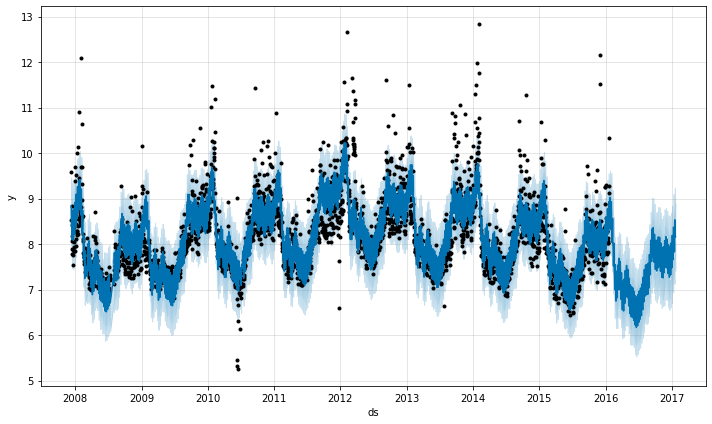

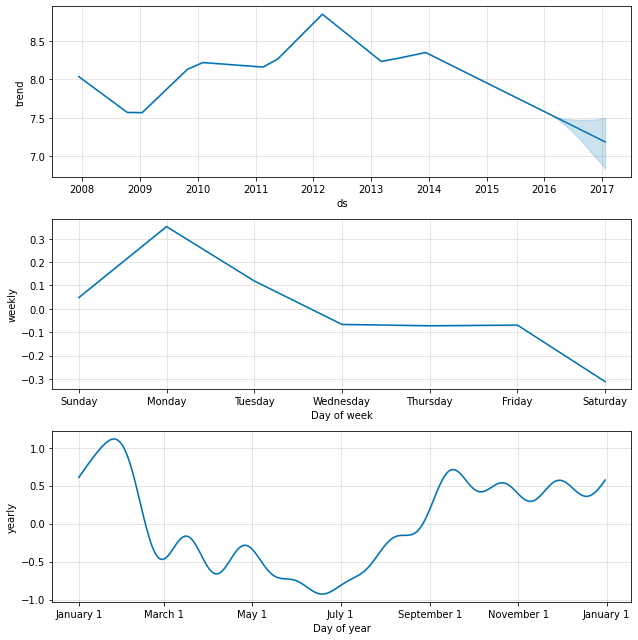

In [11]:
# Python
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [12]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)

In [13]:
plot_components_plotly(m, forecast)

In [15]:
# Cleanup memory 
del df, forecast, future
del m, fig1, fig2

## **Forecasting Growth with Saturating Model**  
https://facebook.github.io/prophet/docs/saturating_forecasts.html

In [16]:
# Load different dataset: page visits to the R (programming language) page on Wikipedia
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2863 entries, 0 to 2862
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      2863 non-null   object 
 1   y       2863 non-null   float64
dtypes: float64(1), object(1)
memory usage: 44.9+ KB


In [17]:
# Set a cap (maximum achievable point, total market size, "carrying capacity")
df['cap'] = 8.5  # Constant in this case, but it doesn't have to be

In [18]:
# Fit historical data to a logistic growth trend model, with a specified carrying capacity
m = Prophet(growth='logistic')
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/jgcz9v5w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/038arf5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18282', 'data', 'file=/tmp/tmpvdb8ig4t/jgcz9v5w.json', 'init=/tmp/tmpvdb8ig4t/038arf5n.json', 'output', 'file=/tmp/tmpvdb8ig4t/prophet_model26xfplro/prophet_model-20221217153244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:32:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:32:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


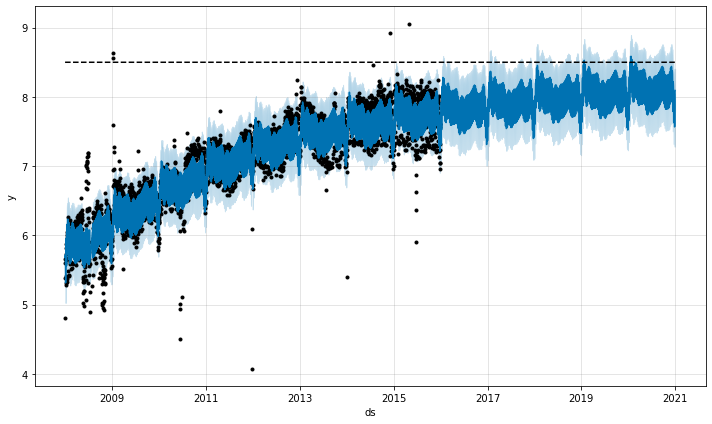

In [19]:
# Predict 5 years into the future, assuming constant capacity
future = m.make_future_dataframe(periods=1826)
future['cap'] = 8.5
fcst = m.predict(future)
fig = m.plot(fcst)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/6ujnfihz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/2cex1l73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52071', 'data', 'file=/tmp/tmpvdb8ig4t/6ujnfihz.json', 'init=/tmp/tmpvdb8ig4t/2cex1l73.json', 'output', 'file=/tmp/tmpvdb8ig4t/prophet_modelqjue3flx/prophet_model-20221217153314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:33:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:33:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


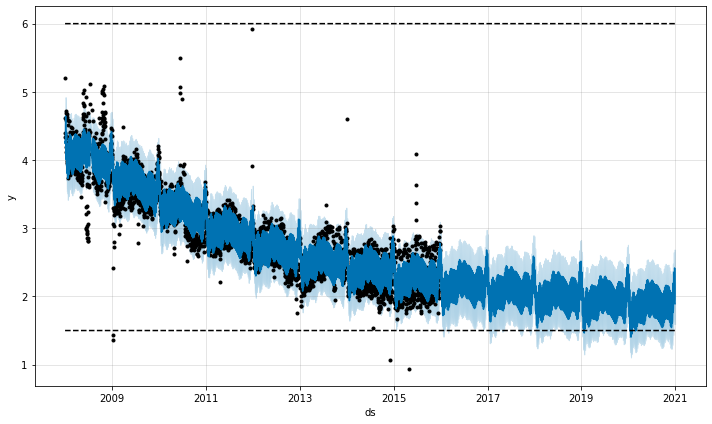

In [20]:
# Saturating Minimum:  Demonstrate how to use a floor
df['y'] = 10 - df['y']
df['cap'] = 6
df['floor'] = 1.5
future['cap'] = 6
future['floor'] = 1.5
m = Prophet(growth='logistic')
m.fit(df)
fcst = m.predict(future)
fig = m.plot(fcst)

In [21]:
# Cleanup memory 
del df, fcst, future
del m, fig

## **Trend Changepoints**  
https://facebook.github.io/prophet/docs/trend_changepoints.html

In [68]:
# Load again the Wikipedia page for Peyton Manning and fit the basic model
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/77_nl_zg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/pb8tcyl0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12222', 'data', 'file=/tmp/tmp1njg5ry4/77_nl_zg.json', 'init=/tmp/tmp1njg5ry4/pb8tcyl0.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_model77gd79yy/prophet_model-20221217071327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:13:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:13:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


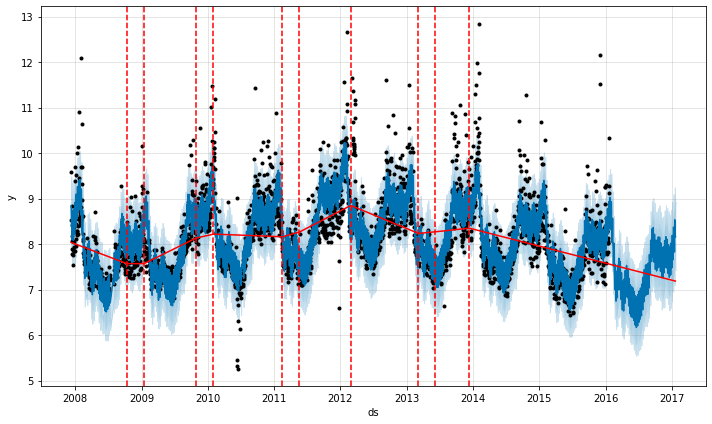

In [69]:
# Show default changepoints 
# By default, Prophet specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series.
# Then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization). 
# To extend changeoints to the first 90% of the timeseries: m = Prophet(changepoint_range=0.9) 
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/8zsxrjqg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/eehcu_31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70632', 'data', 'file=/tmp/tmp1njg5ry4/8zsxrjqg.json', 'init=/tmp/tmp1njg5ry4/eehcu_31.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelmujgulqn/prophet_model-20221217072036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:20:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:20:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


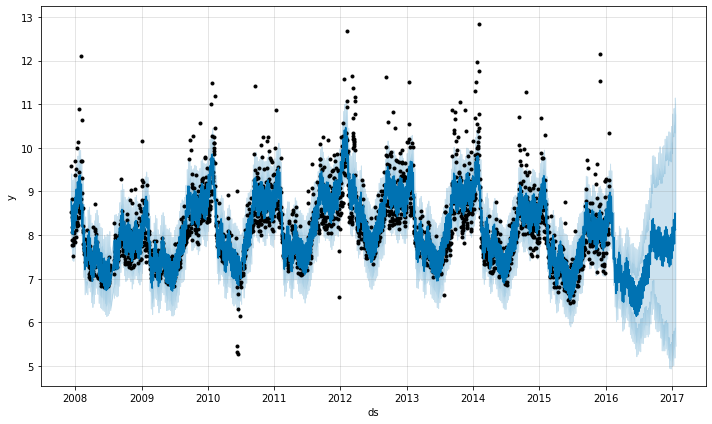

In [70]:
# Adjusting trend flexibility
#  - Situation: When trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), 
#  - Solution:  Adjust the strength of the sparse prior using the input argument changepoint_prior_scale. 
#               By default, this parameter is set to 0.05. Increasing it will make the trend more flexible.
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/fi40hv8_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/6hn5vlhd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70041', 'data', 'file=/tmp/tmp1njg5ry4/fi40hv8_.json', 'init=/tmp/tmp1njg5ry4/6hn5vlhd.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelwhdpa2ys/prophet_model-20221217072049.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:20:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:20:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


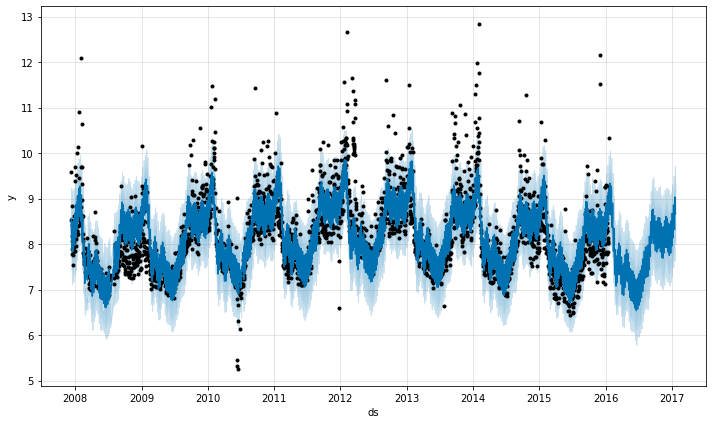

In [71]:
# Decreasing it will make the trend less flexible
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/1hj3867z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/acuhv2k8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20440', 'data', 'file=/tmp/tmp1njg5ry4/1hj3867z.json', 'init=/tmp/tmp1njg5ry4/acuhv2k8.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelvbjaqtdh/prophet_model-20221217072334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


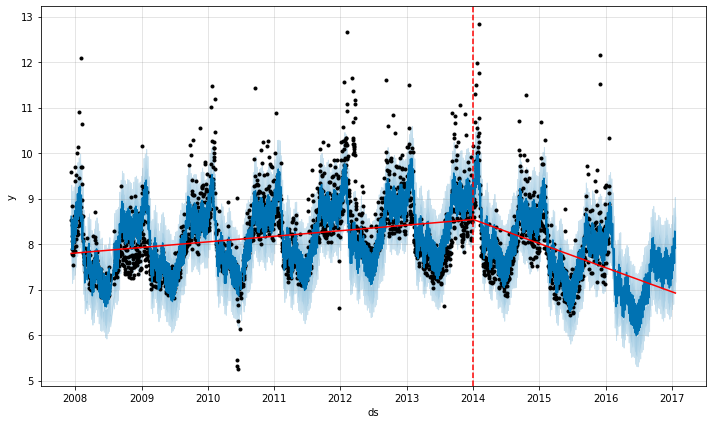

In [73]:
# Manually specifying the locations of the changepoints
# - Slope changes will then be allowed only at these points, with the same sparse regularization as before.
# - Alternative option: keep the automatic detection and just add manual additional changepoints if Prophet missed any
m = Prophet(changepoints=['2014-01-01'])
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [74]:
# Cleanup 
del df, future, forecast
del m, fig, a 

## **Seasonality, Holiday Effects, And Regressors**  

Source: https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

In [77]:
# Load again the Wikipedia page for Peyton Manning and fit the basic model
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/43b8i4tt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/jbrz8an9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14620', 'data', 'file=/tmp/tmp1njg5ry4/43b8i4tt.json', 'init=/tmp/tmp1njg5ry4/jbrz8an9.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelrybrgebx/prophet_model-20221217073626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [78]:
# Modeling Holidays and Special Events
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((playoffs, superbowls))
holidays

holiday         ds  lower_window  upper_window
0     playoff 2008-01-13             0             1
1     playoff 2009-01-03             0             1
2     playoff 2010-01-16             0             1
3     playoff 2010-01-24             0             1
4     playoff 2010-02-07             0             1
5     playoff 2011-01-08             0             1
6     playoff 2013-01-12             0             1
7     playoff 2014-01-12             0             1
8     playoff 2014-01-19             0             1
9     playoff 2014-02-02             0             1
10    playoff 2015-01-11             0             1
11    playoff 2016-01-17             0             1
12    playoff 2016-01-24             0             1
13    playoff 2016-02-07             0             1
0   superbowl 2010-02-07             0             1
1   superbowl 2014-02-02             0             1
2   superbowl 2016-02-07             0             1

In [79]:
# Fit model including holiday effects
m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/i6tlyfr_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/th6psf41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62582', 'data', 'file=/tmp/tmp1njg5ry4/i6tlyfr_.json', 'init=/tmp/tmp1njg5ry4/th6psf41.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modeljes6pg7k/prophet_model-20221217073640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [80]:
# See the holiday effect in the forecast dataframe
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

ds  playoff  superbowl
2190 2014-02-02  1.22176   1.208297
2191 2014-02-03  1.90146   1.459763
2532 2015-01-11  1.22176   0.000000
2533 2015-01-12  1.90146   0.000000
2901 2016-01-17  1.22176   0.000000
2902 2016-01-18  1.90146   0.000000
2908 2016-01-24  1.22176   0.000000
2909 2016-01-25  1.90146   0.000000
2922 2016-02-07  1.22176   1.208297
2923 2016-02-08  1.90146   1.459763

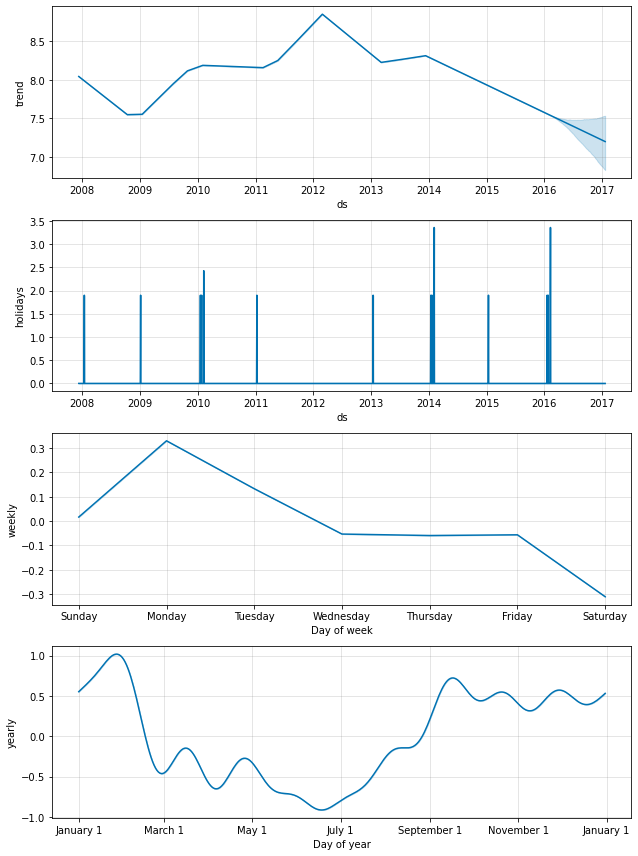

In [81]:
# Component plots will include holiday effects
fig = m.plot_components(forecast)

In [82]:
# Built-in Country Holidays
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/jk446r75.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/h35ddbmi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95023', 'data', 'file=/tmp/tmp1njg5ry4/jk446r75.json', 'init=/tmp/tmp1njg5ry4/h35ddbmi.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_model9klfi1kz/prophet_model-20221217074028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:40:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:40:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [83]:
# US holidays that are included
m.train_holiday_names

0                         playoff
1                       superbowl
2                  New Year's Day
3      Martin Luther King Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7                       Labor Day
8                    Columbus Day
9                    Veterans Day
10                   Thanksgiving
11                  Christmas Day
12       Christmas Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
15      New Year's Day (Observed)
dtype: object

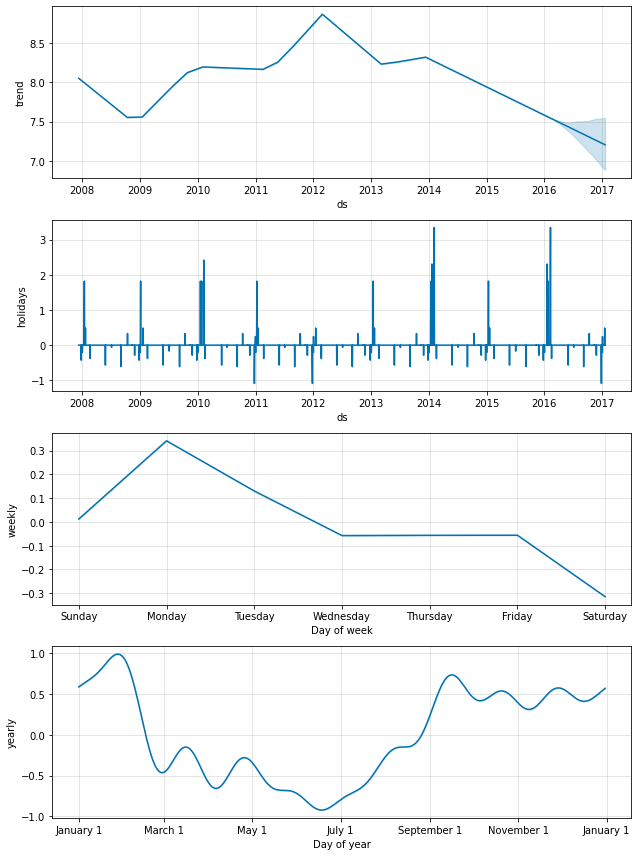

In [84]:
# Python
forecast = m.predict(future)
fig = m.plot_components(forecast)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/vp1r42g9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/s3xdj7yo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8435', 'data', 'file=/tmp/tmp1njg5ry4/vp1r42g9.json', 'init=/tmp/tmp1njg5ry4/s3xdj7yo.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_model7f934ja5/prophet_model-20221217074514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


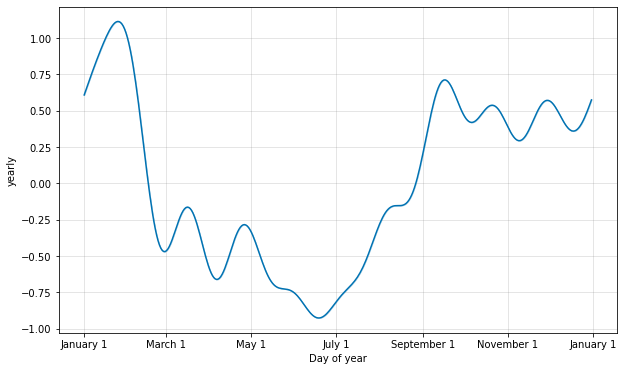

In [85]:
# Fourier Order for Seasonalities
# By default:
# - Yearly seasonality with Fourier order of 10 
# - Weekly seasonality with Fourier order of 3
# - Daily seasonality for a sub-daily time series, if the time series is more than two cycles long
# - No other seasonalitys included by default (monthly, quarterly, hourly) but can be added manually 
from prophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/_9jbzj3y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/q62cwtb0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95079', 'data', 'file=/tmp/tmp1njg5ry4/_9jbzj3y.json', 'init=/tmp/tmp1njg5ry4/q62cwtb0.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelebf6l4_p/prophet_model-20221217074559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


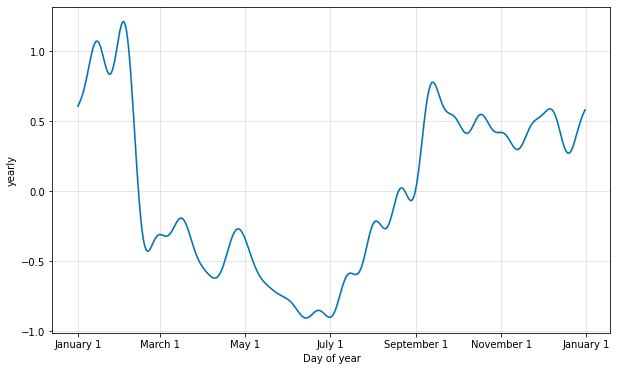

In [86]:
# Increase order when the seasonality needs to fit higher-frequency changes (but can also lead to overfitting)
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/cl94_tk8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/l07m92zq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93605', 'data', 'file=/tmp/tmp1njg5ry4/cl94_tk8.json', 'init=/tmp/tmp1njg5ry4/l07m92zq.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelphttq6k3/prophet_model-20221217074947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


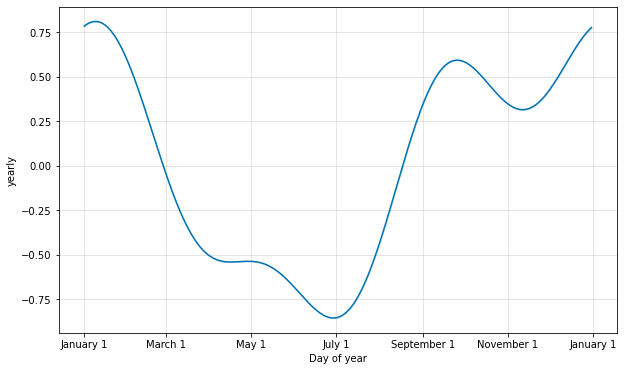

In [88]:
# Decrease order when the seasonality needs to fit lower-frequency changes (but can also lead to underfitting)
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=3).fit(df)
a = plot_yearly(m)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/fjoqdzoj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/0yuffcpk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90634', 'data', 'file=/tmp/tmp1njg5ry4/fjoqdzoj.json', 'init=/tmp/tmp1njg5ry4/0yuffcpk.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_model1r82npbc/prophet_model-20221217075345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:53:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:53:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


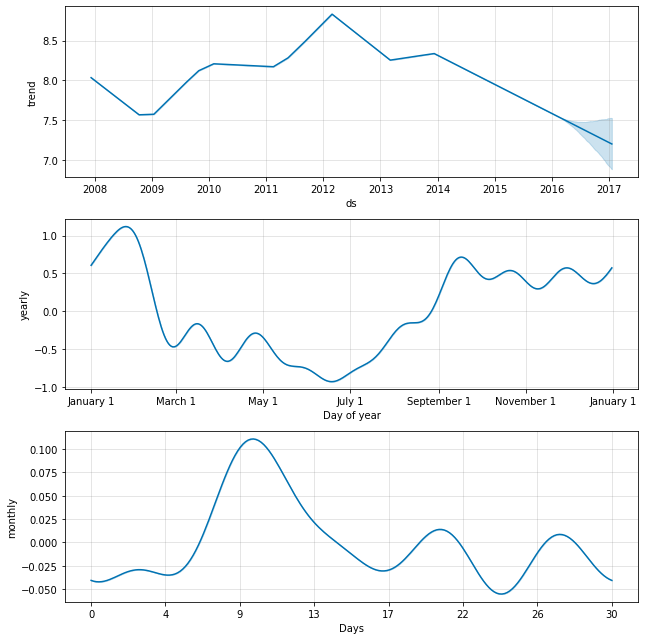

In [89]:
# Specifying Custom Seasonalities
# - Example: Replace the weekly seasonality with monthly seasonality:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

In [91]:
# Conditional seasonalities (seasonalities that depend on other factors)
# - Example: weekly seasonal pattern that is different during football season than it is during the rest of the year
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

df['on_season'] = df['ds'].apply(is_nfl_season)
df['off_season'] = ~df['ds'].apply(is_nfl_season)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ds          2905 non-null   object 
 1   y           2905 non-null   float64
 2   on_season   2905 non-null   bool   
 3   off_season  2905 non-null   bool   
dtypes: bool(2), float64(1), object(1)
memory usage: 51.2+ KB


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/zfil65ct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/w9p_42r6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76281', 'data', 'file=/tmp/tmp1njg5ry4/zfil65ct.json', 'init=/tmp/tmp1njg5ry4/w9p_42r6.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelmha6mgz2/prophet_model-20221217075909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:59:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


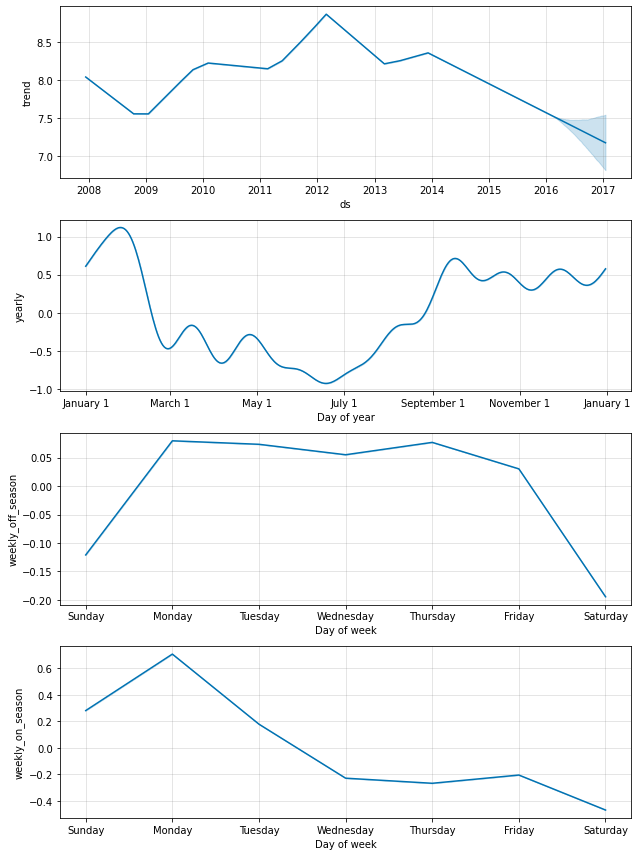

In [92]:
# Disable the built-in weekly seasonality, and replace it with two weekly seasonalities that have these columns specified as a condition
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season' , period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')

future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

In [93]:
# Prior scale for holidays and seasonality
# - If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using the parameter "holidays_prior_scale" 
# - By default this parameter is 10, which provides very little regularization. Reducing this parameter dampens holiday effects.
# - There is a parameter "seasonality_prior_scale" which similarly adjusts the extent to which the seasonality model will fit the data.
# - Prior scales can be set separately for individual holidays by including a column "prior_scale" in the holidays dataframe. 
# - Prior scales for individual seasonalities can be passed as an argument to add_seasonality. 
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/kqxtur57.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/2v0wb9d7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33450', 'data', 'file=/tmp/tmp1njg5ry4/kqxtur57.json', 'init=/tmp/tmp1njg5ry4/2v0wb9d7.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modellr97hvkq/prophet_model-20221217080126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:01:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds   playoff  superbowl
2190 2014-02-02  1.207765   0.963348
2191 2014-02-03  1.855854   0.990907
2532 2015-01-11  1.207765   0.000000
2533 2015-01-12  1.855854   0.000000
2901 2016-01-17  1.207765   0.000000
2902 2016-01-18  1.855854   0.000000
2908 2016-01-24  1.207765   0.000000
2909 2016-01-25  1.855854   0.000000
2922 2016-02-07  1.207765   0.963348
2923 2016-02-08  1.855854   0.990907

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/4rpoo9in.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/yqypusxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66658', 'data', 'file=/tmp/tmp1njg5ry4/4rpoo9in.json', 'init=/tmp/tmp1njg5ry4/yqypusxt.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_model6tv_5wli/prophet_model-20221217080523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:05:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:05:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


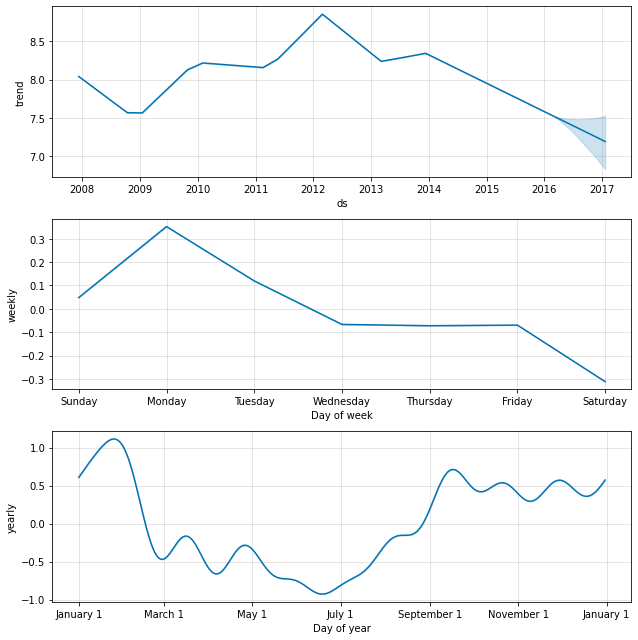

In [94]:
# Example: the prior scale for just weekly seasonality can be set using:
m = Prophet()
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=0.1)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/jtgovgiw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/8tsjtnhu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77957', 'data', 'file=/tmp/tmp1njg5ry4/jtgovgiw.json', 'init=/tmp/tmp1njg5ry4/8tsjtnhu.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelt4qfe8fv/prophet_model-20221217081013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:10:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:10:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


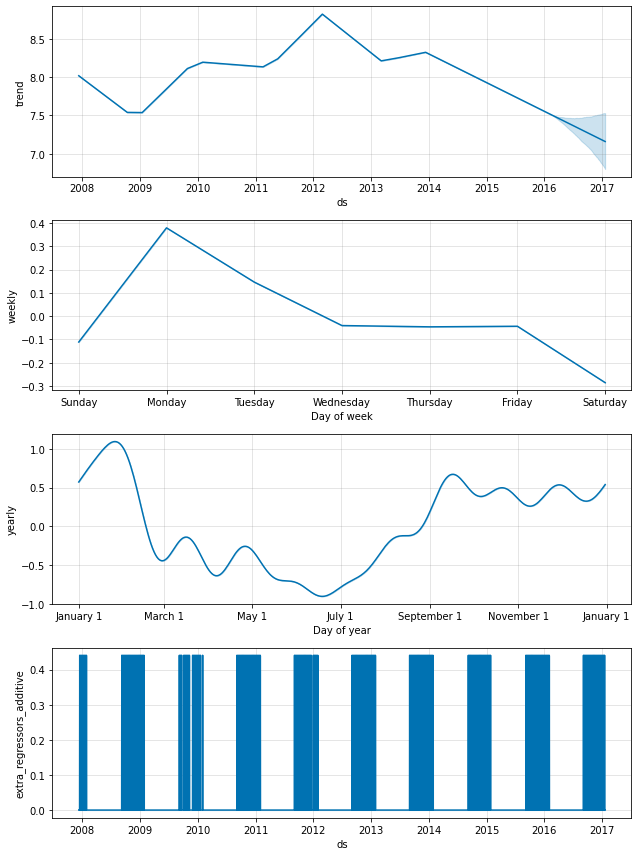

In [95]:
# Additional regressors
# - Add it to the data sets (historical and future)
# - Specify it with function "add_regressor"

def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
fig = m.plot_components(forecast)

In [97]:
from prophet.utilities import regressor_coefficients 
regressor_coefficients(m)

regressor regressor_mode  center  coef_lower      coef  coef_upper
0  nfl_sunday       additive     0.0    0.441139  0.441139    0.441139

In [98]:
# Cleanup
del df, future, forecast
del playoffs, superbowls, holidays
del m, fig, a

## **Multiplicative Seasonality**  
https://facebook.github.io/prophet/docs/multiplicative_seasonality.html

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/j922s897.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/qvzd7j_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65536', 'data', 'file=/tmp/tmp1njg5ry4/j922s897.json', 'init=/tmp/tmp1njg5ry4/qvzd7j_m.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelmejg2me0/prophet_model-20221217082011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:20:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:20:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


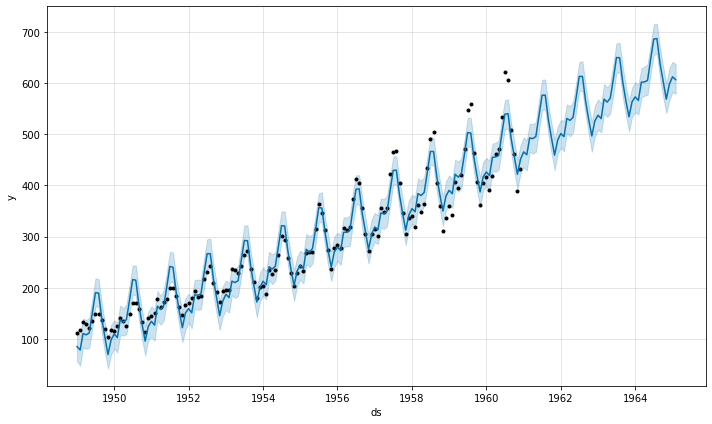

In [100]:
# Default: Additive Seasonality
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/5ic2xffq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/cmsn0i_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20209', 'data', 'file=/tmp/tmp1njg5ry4/5ic2xffq.json', 'init=/tmp/tmp1njg5ry4/cmsn0i_q.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_model0_0k8rwg/prophet_model-20221217082016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:20:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:20:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


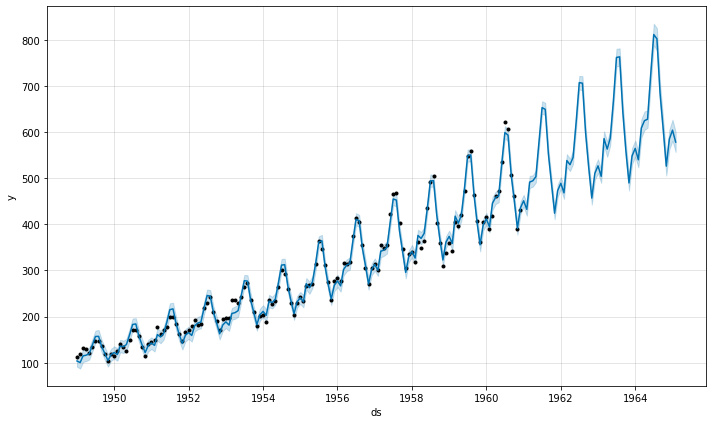

In [101]:
# Multiplicative Seasonality
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)

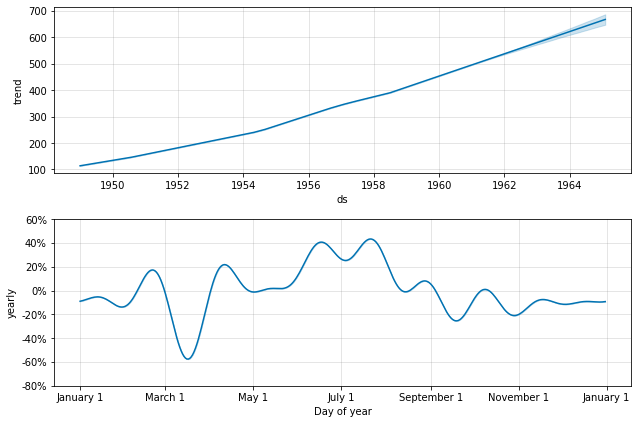

In [102]:
# The components figure will now show the seasonality as a percent of the trend
fig = m.plot_components(forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/pk21fks4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/h964kq3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99712', 'data', 'file=/tmp/tmp1njg5ry4/pk21fks4.json', 'init=/tmp/tmp1njg5ry4/h964kq3c.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modeliktqve41/prophet_model-20221217082858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


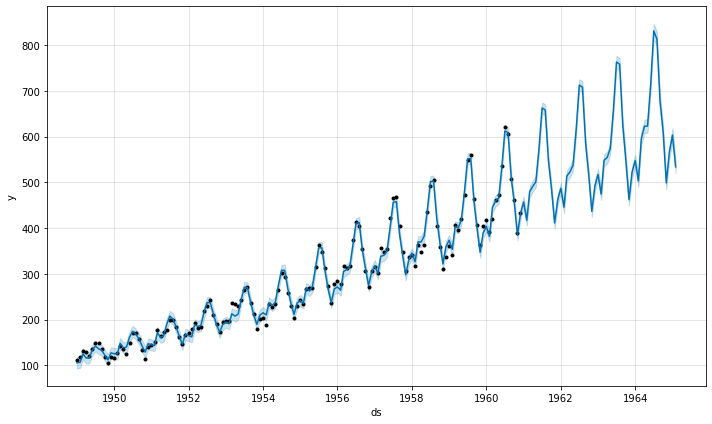

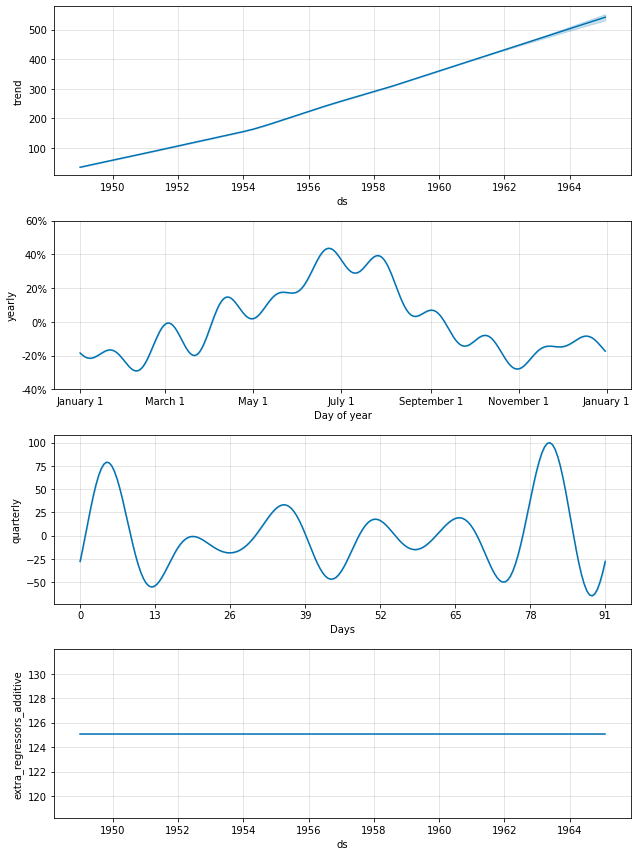

In [108]:
# Example: multiplicative built-in seasonalities + additive quarterly seasonality and an additive regressor:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv')
df['regressor'] = 100

m = Prophet(seasonality_mode='multiplicative')
m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
m.add_regressor('regressor', mode='additive')
m.fit(df)

future = m.make_future_dataframe(50, freq='MS')
future['regressor'] = 100

forecast = m.predict(future)
fig = m.plot(forecast)
fig = m.plot_components(forecast)

In [109]:
# Cleanup
del df, future, forecast
del m, fig

## **Uncertainty Intervals**  
https://facebook.github.io/prophet/docs/uncertainty_intervals.html

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/wrt2t6cs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/awjkml9l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99525', 'data', 'file=/tmp/tmp1njg5ry4/wrt2t6cs.json', 'init=/tmp/tmp1njg5ry4/awjkml9l.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelstp47nlm/prophet_model-20221217084120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:41:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


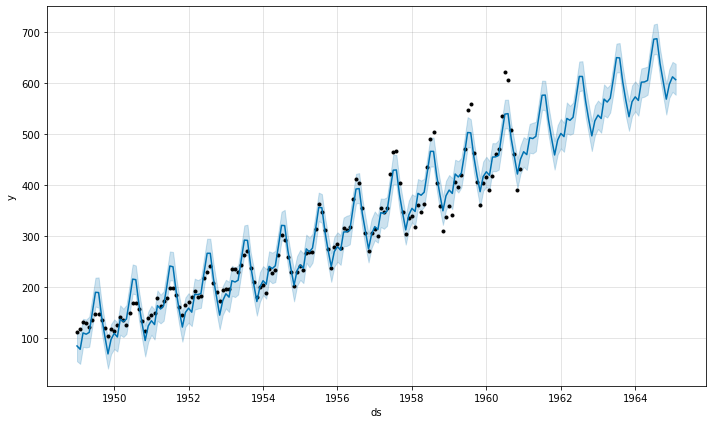

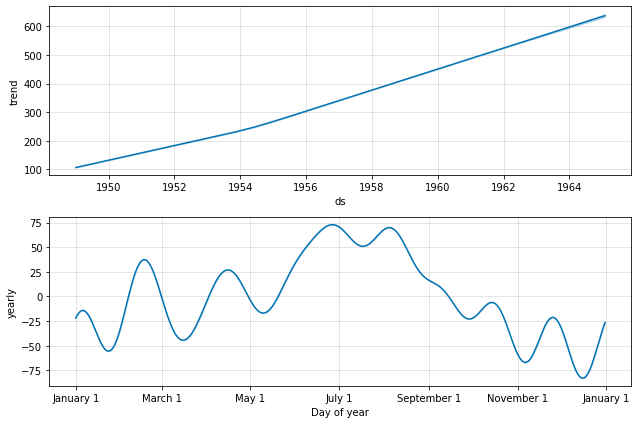

In [110]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv')

m = Prophet()
m.fit(df)

future = m.make_future_dataframe(50, freq='MS')
forecast = m.predict(future)

fig = m.plot(forecast)
fig = m.plot_components(forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/cx1edg51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/kif1zkqp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86290', 'data', 'file=/tmp/tmp1njg5ry4/cx1edg51.json', 'init=/tmp/tmp1njg5ry4/kif1zkqp.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelwpb3ivi6/prophet_model-20221217084221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


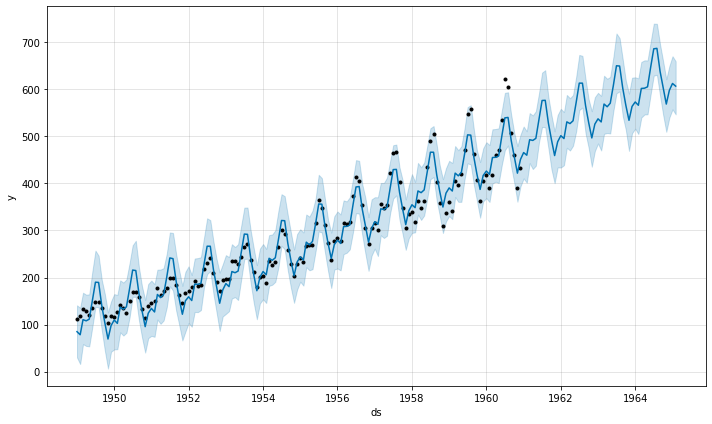

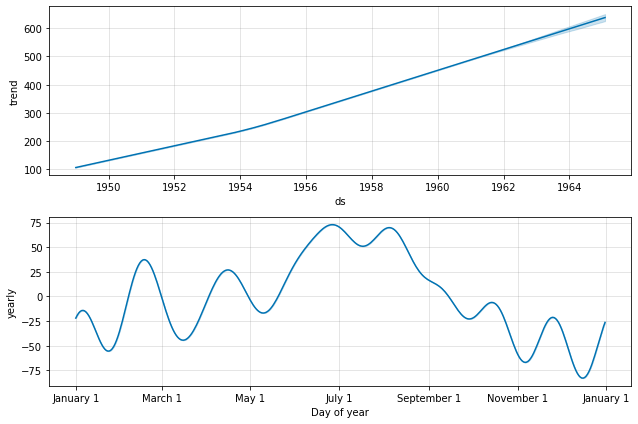

In [113]:
# Uncertainty in the trend
# - If we increase changepoint_prior_scale, will increase the forecast uncertainty, 
#   because if we model more rate changes in the history then we will expect more in the future, 
#   and makes the uncertainty intervals a useful indicator of overfitting.
# - The width of the uncertainty intervals (by default 80%) can be set using the parameter interval_width:
forecast = Prophet(interval_width=0.99).fit(df).predict(future)
fig = m.plot(forecast)
fig = m.plot_components(forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/q9hkkkiq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/0dczauzz.json
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:Command ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'info']
	error during processing Machine is not on the network
08:44:22 - cmdstanpy - INFO - CmdStan installation /usr/local/lib/python3.8/dist-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
INFO:cmdstanpy:CmdStan installation /usr/local/lib/python3.8/dist-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
08:44:22 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
INFO:

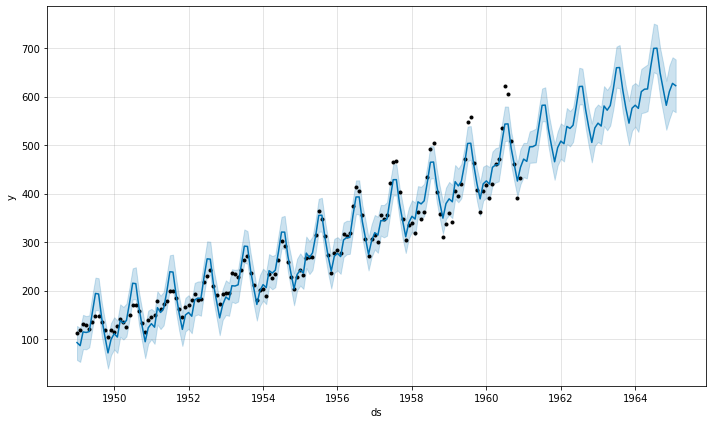

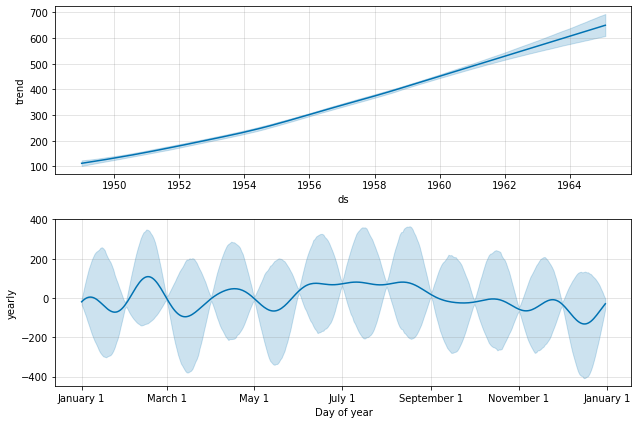

In [114]:
# Uncertainty in seasonality
# By default Prophet will only return uncertainty in the trend and observation noise. 
# To get uncertainty in seasonality, you must do full Bayesian sampling. 
m = Prophet(mcmc_samples=300)
forecast = m.fit(df, show_progress=False).predict(future)
fig = m.plot(forecast)
fig = m.plot_components(forecast)

In [115]:
# You can access the raw posterior predictive samples in Python 
m.predictive_samples(future)

{'yhat': array([[ 39.68191627, 108.85790463,  75.31653735, ..., 100.05315229,
         136.82628782,  92.75989185],
        [ 95.18428845,  84.97215369,  94.67502395, ...,  81.18906208,
          78.65209001,  53.4342847 ],
        [ 96.25025238, 123.94147375, 125.33813402, ...,  85.11558144,
         117.39929898, 111.00302212],
        ...,
        [597.51837824, 600.31340583, 561.76410678, ..., 560.32346047,
         555.28096699, 611.59676642],
        [610.71327744, 610.12608786, 673.99234528, ..., 637.19051833,
         593.61928079, 636.69599785],
        [638.98793344, 635.50740879, 668.80422186, ..., 611.21277352,
         631.91183033, 622.1991148 ]]),
 'trend': array([[114.075422  , 114.075422  , 108.51412   , ..., 105.821482  ,
         112.088754  , 112.088754  ],
        [116.17233064, 116.17233064, 110.34632648, ..., 107.2792712 ,
         113.82989822, 113.82989822],
        [118.06631264, 118.06631264, 112.00122265, ..., 108.59598403,
         115.40254461, 115.4025446

In [116]:
# Cleanup
del df, future, forecast
del m, fig

## **Outliers**  
https://facebook.github.io/prophet/docs/outliers.html

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/731i4pav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/t2_czcrb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86740', 'data', 'file=/tmp/tmp1njg5ry4/731i4pav.json', 'init=/tmp/tmp1njg5ry4/t2_czcrb.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelwxp78p5a/prophet_model-20221217085519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:55:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:55:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


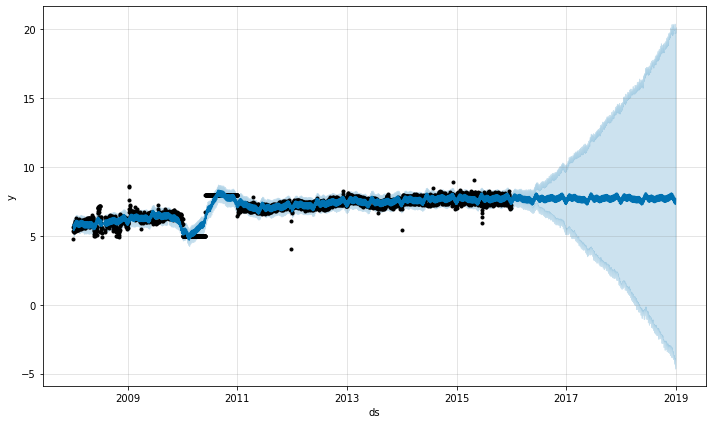

In [117]:
# Situation #1: Outliers impact the width of the prediction intervals
# Load table with a block of bad data
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers1.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/mh244vs3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/vp30ifu8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16713', 'data', 'file=/tmp/tmp1njg5ry4/mh244vs3.json', 'init=/tmp/tmp1njg5ry4/vp30ifu8.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelwxa200ie/prophet_model-20221217085531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:55:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:55:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


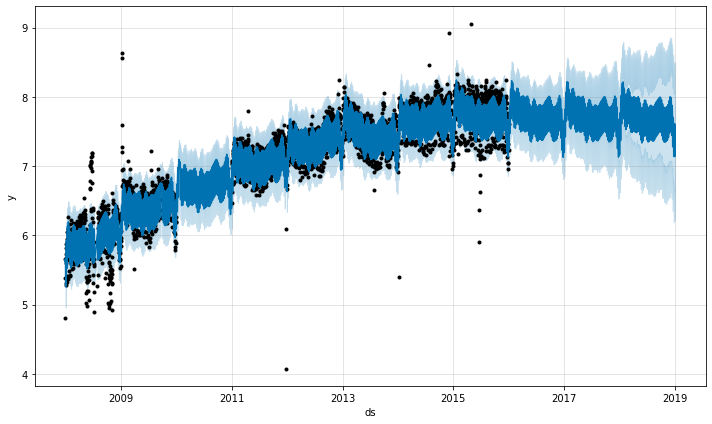

In [118]:
# Remove outliers
# Prophet has no problem with missing data
df.loc[(df['ds'] > '2010-01-01') & (df['ds'] < '2011-01-01'), 'y'] = None
model = Prophet().fit(df)
fig = model.plot(model.predict(future))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/e6q0sb4_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/90m0_9zn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16935', 'data', 'file=/tmp/tmp1njg5ry4/e6q0sb4_.json', 'init=/tmp/tmp1njg5ry4/90m0_9zn.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_model1nek13e1/prophet_model-20221217085901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:59:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:59:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


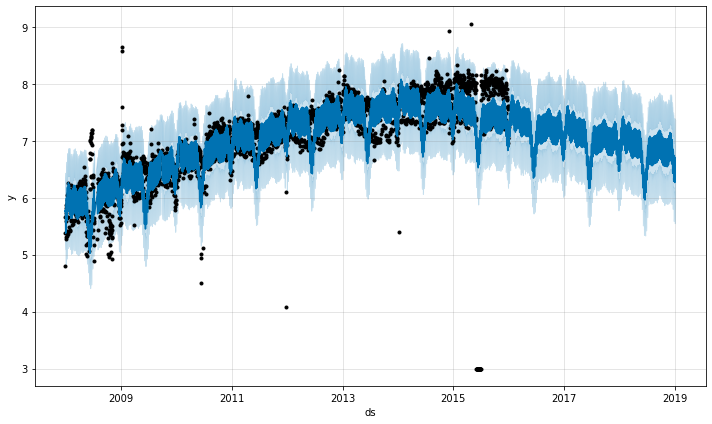

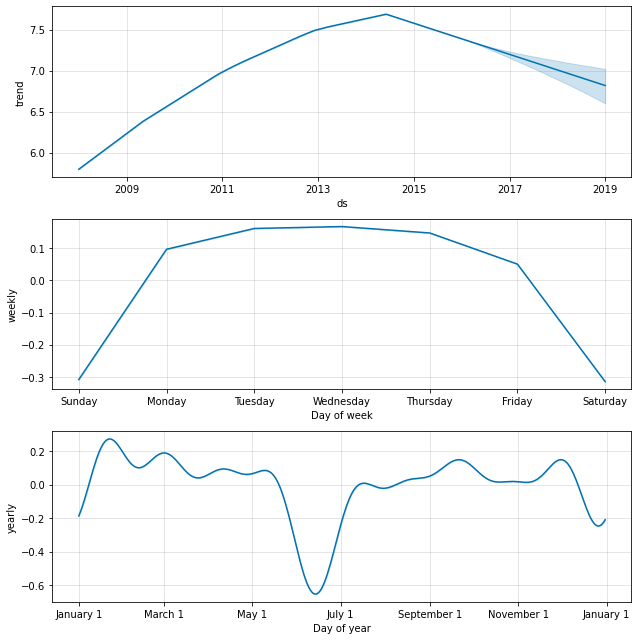

In [120]:
# Situation #2: Outliers affect the trend
# Example: Load data with added outiers (extreme outliers in June 2015 that mess up the seasonality estimate, so their effect reverberates into the future forever.)
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_R_outliers2.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=1096)
forecast = m.predict(future)
fig = m.plot(forecast)
fig = m.plot_components(forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/00qwezfn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1njg5ry4/uk0sfu1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66792', 'data', 'file=/tmp/tmp1njg5ry4/00qwezfn.json', 'init=/tmp/tmp1njg5ry4/uk0sfu1z.json', 'output', 'file=/tmp/tmp1njg5ry4/prophet_modelt3tf8pwi/prophet_model-20221217090214.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:02:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:02:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


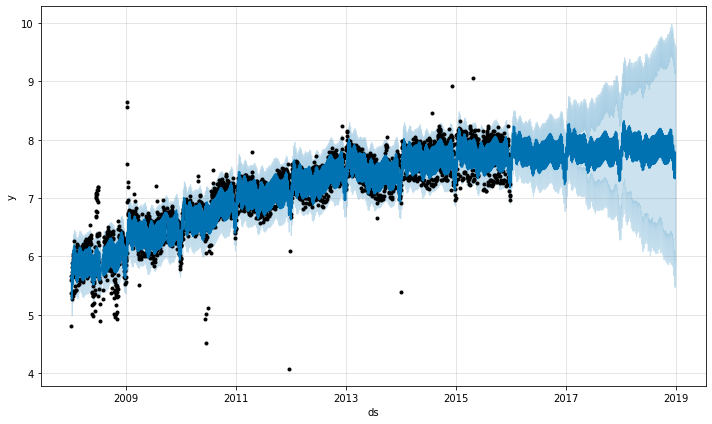

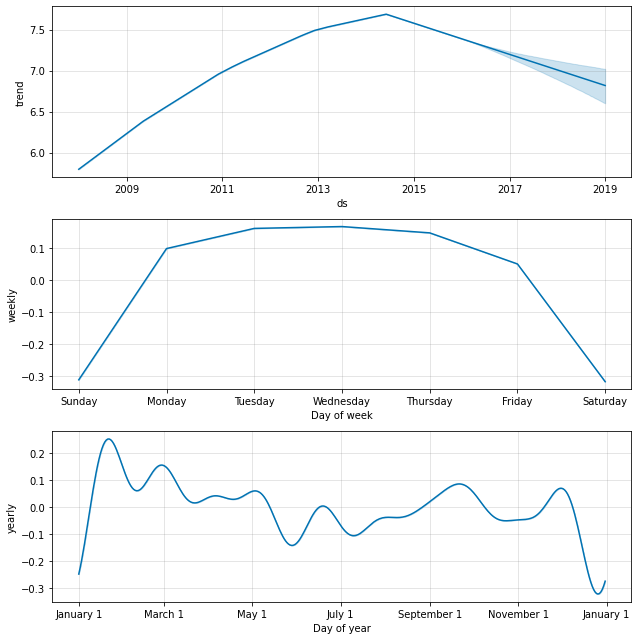

In [123]:
# Remove extreme outliers 
df.loc[(df['ds'] > '2015-06-01') & (df['ds'] < '2015-06-30'), 'y'] = None
m = Prophet().fit(df)
fig = m.plot(m.predict(future))
fig = m.plot_components(forecast)

In [126]:
# Cleanup
del df, future, forecast
del model, m, fig

## **Non-Daily Data**  
https://facebook.github.io/prophet/docs/non-daily_data.html

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/ukf50yn2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/nu7t9_0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86918', 'data', 'file=/tmp/tmpvdb8ig4t/ukf50yn2.json', 'init=/tmp/tmpvdb8ig4t/nu7t9_0d.json', 'output', 'file=/tmp/tmpvdb8ig4t/prophet_model36nno4ed/prophet_model-20221217153730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:37:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:37:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


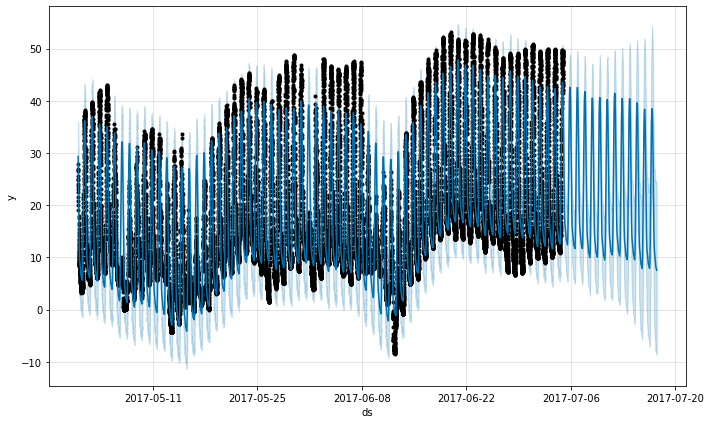

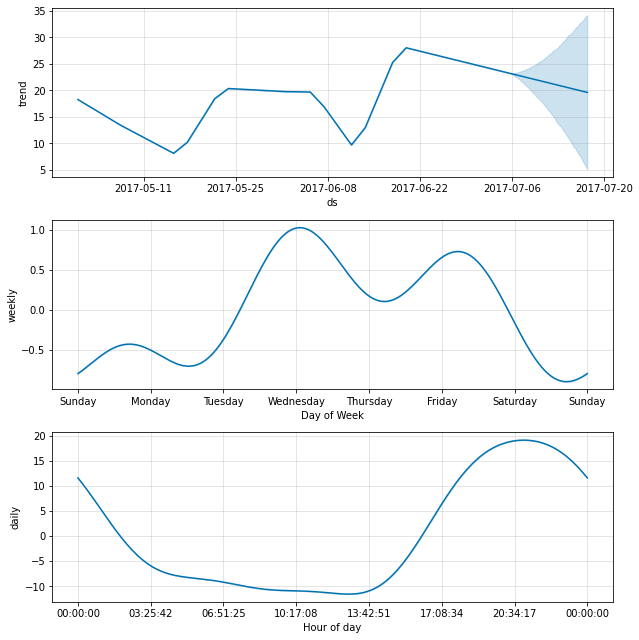

In [22]:
# Sub-daily data
# - The format of the timestamps should be YYYY-MM-DD HH:MM:SS
# - When sub-daily data are used, daily seasonality will automatically be fit
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_yosemite_temps.csv')
m = Prophet(changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)
fig = m.plot_components(fcst)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/1gb8jdg2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/efvc7qon.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96219', 'data', 'file=/tmp/tmpvdb8ig4t/1gb8jdg2.json', 'init=/tmp/tmpvdb8ig4t/efvc7qon.json', 'output', 'file=/tmp/tmpvdb8ig4t/prophet_modelltb9y0rw/prophet_model-20221217153743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:37:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:37:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


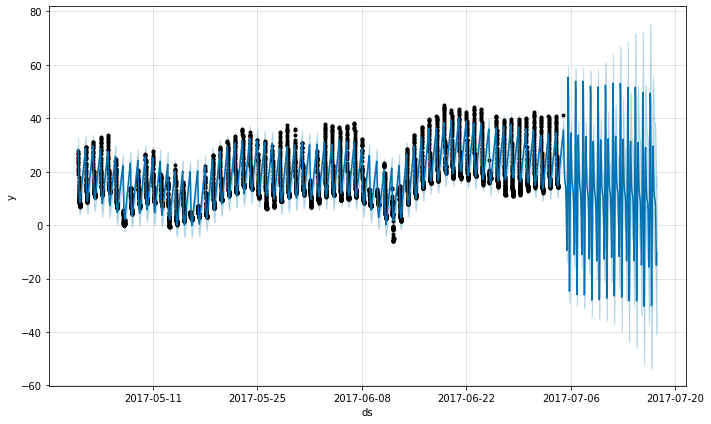

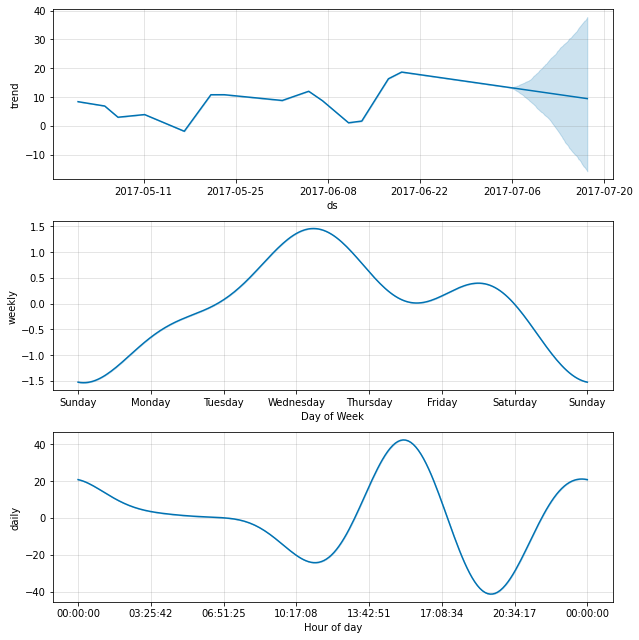

In [23]:
# Data with regular gaps
# - Example: Suppose the dataset above only had observations from 12a to 6a:
# - But an error is made: we dont apply the same to the future dataset
df2 = df.copy()
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2[df2['ds'].dt.hour < 6]
m = Prophet().fit(df2)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)
fig = m.plot_components(fcst)

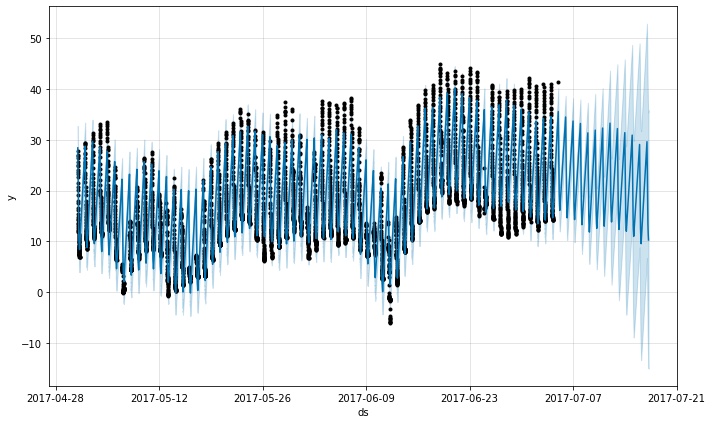

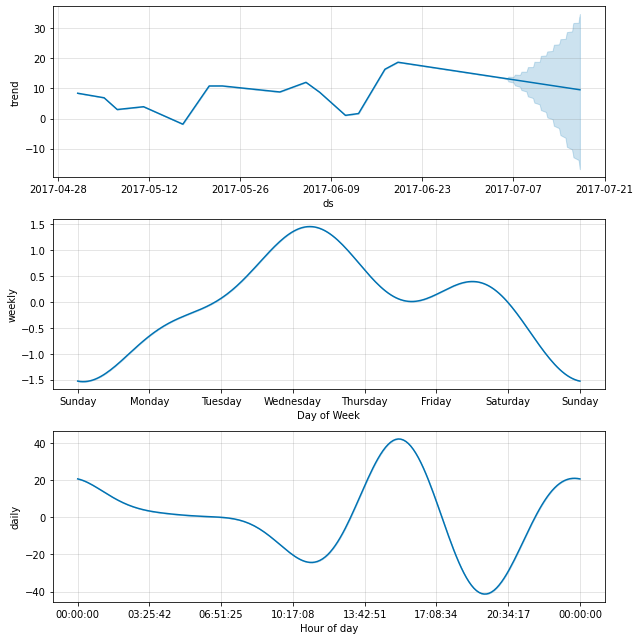

In [24]:
# Make sure that we are forecasting for data that we have in the history as well:
future2 = future.copy()
future2 = future2[future2['ds'].dt.hour < 6]
fcst = m.predict(future2)
fig = m.plot(fcst)
fig = m.plot_components(fcst)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/8ft0rptp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/8_q0pgak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7286', 'data', 'file=/tmp/tmpvdb8ig4t/8ft0rptp.json', 'init=/tmp/tmpvdb8ig4t/8_q0pgak.json', 'output', 'file=/tmp/tmpvdb8ig4t/prophet_modelv7gr8pmn/prophet_model-20221217153818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:38:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:38:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


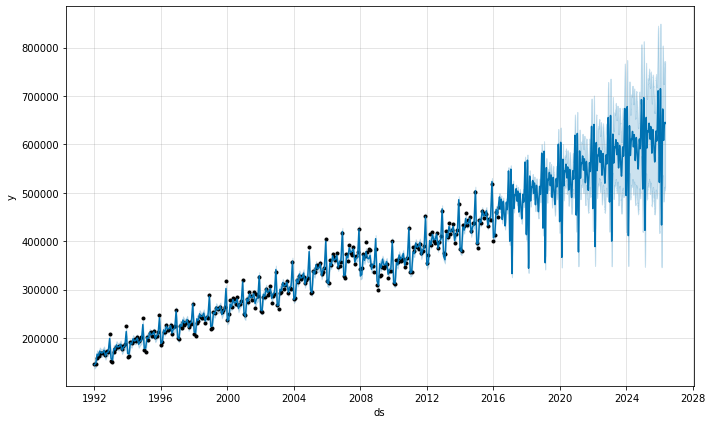

In [25]:
# Monthly data
# You can use Prophet to fit monthly data. 
# However, the underlying model is continuous-time, which means that you can get strange results if you fit the model to monthly data and then ask for daily forecasts. 
# Example: forecast US retail sales volume for the next 10 years
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_retail_sales.csv')
m = Prophet(seasonality_mode='multiplicative').fit(df)
future = m.make_future_dataframe(periods=3652)
fcst = m.predict(future)
fig = m.plot(fcst)

In [26]:
df.head(10)

ds       y
0  1992-01-01  146376
1  1992-02-01  147079
2  1992-03-01  159336
3  1992-04-01  163669
4  1992-05-01  170068
5  1992-06-01  168663
6  1992-07-01  169890
7  1992-08-01  170364
8  1992-09-01  164617
9  1992-10-01  173655

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/7u31p_1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvdb8ig4t/kcurfrb4.json
DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:Command ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'info']
	error during processing Machine is not on the network
15:38:28 - cmdstanpy - INFO - CmdStan installation /usr/local/lib/python3.8/dist-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
INFO:cmdstanpy:CmdStan installation /usr/local/lib/python3.8/dist-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
15:38:28 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
INFO:

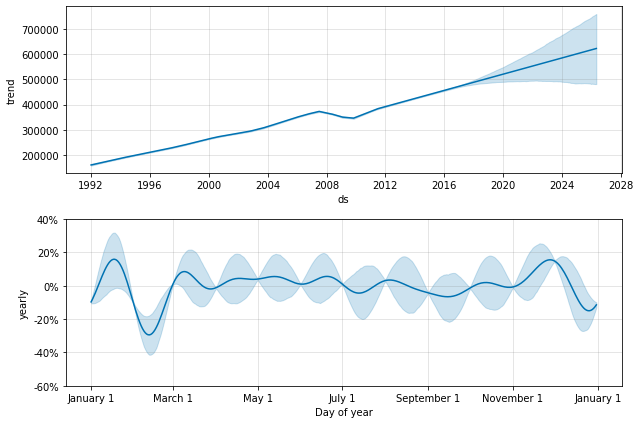

In [27]:
# Root cause: When we fit the yearly seasonality, it only has data for the first of each month and the seasonality components for the remaining days are unidentifiable and overfit. 
# This can be clearly seen by doing MCMC to see uncertainty in the seasonality:
m = Prophet(seasonality_mode='multiplicative', mcmc_samples=300).fit(df, show_progress=False)
fcst = m.predict(future)
fig = m.plot_components(fcst)

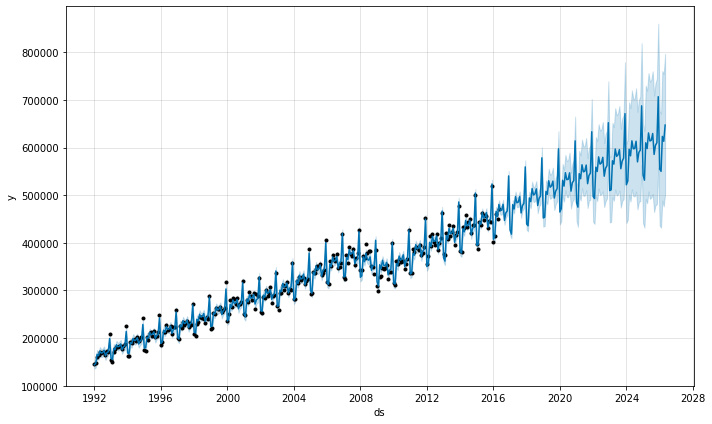

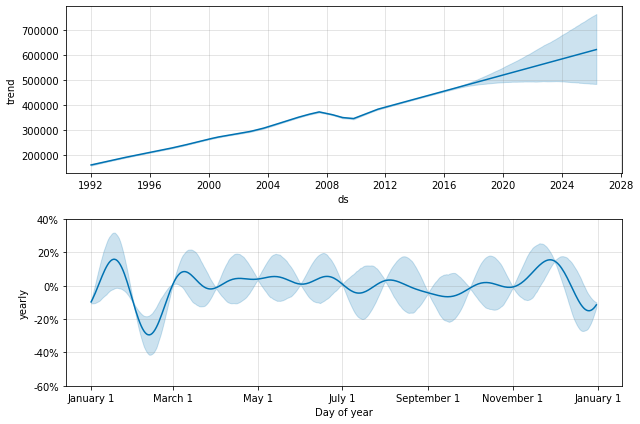

In [28]:
# Solution: When fitting Prophet to monthly data, only make monthly forecasts (pass the right frequency)
# MS = month-start
future = m.make_future_dataframe(periods=120, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)
fig = m.plot_components(fcst)

In [31]:
# Cleanup
del df, df2, future, future2, fcst
del m, fig

## **Diagnostics**  
https://facebook.github.io/prophet/docs/diagnostics.html

In [119]:
# Load again the Wikipedia page for Peyton Manning and fit the basic model
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t3n_d8m/tg7dj7ua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t3n_d8m/4xqst7_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87011', 'data', 'file=/tmp/tmp4t3n_d8m/tg7dj7ua.json', 'init=/tmp/tmp4t3n_d8m/4xqst7_3.json', 'output', 'file=/tmp/tmp4t3n_d8m/prophet_model_du1mpli/prophet_model-20221218002900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:29:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:29:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [120]:
# Cross validation
# - Goal: measure forecast error using historical data
# - Approach: Selec cutoff points in history. For each, fit the model using data only up to that cutoff. Then compare forecasted vs actual for the hold out data.
# - Parameters:
#     - horizon = forecast horizon
#     - initial = size of the initial training period (optional, default = three times the horizon) 
#     - period = spacing between cutoff dates (optional, default = cutoffs made every half a horizon)
#     - note: string for initial, period, and horizon should be in the format used by Pandas Timedelta, which accepts units of days or shorter.
# - Example:
#     Cross-validation to assess prediction performance on a horizon of 365 days, starting with 730 days of training data in the first cutoff and then making predictions every 180 days. 
#     On this 8 year time series, this corresponds to 11 total forecasts.
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:prophet:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t3n_d8m/v3_wo81p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t3n_d8m/y6ii95vi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31988', 'data', 'file=/tmp/tmp4t3n_d8m/v3_wo81p.json', 'init=/tmp/tmp4t3n_d8m/y6ii95vi.json', 'output', 'file=/tmp/tmp4t3n_d8m/prophet_modelijr_eih9/prophet_model-20221218002914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:29:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:29:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t3n_d8m/i81ih4vf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t3n_d8m/fx98g4cb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2010-02-16  8.954355    8.479161    9.473807  8.242493 2010-02-15
1 2010-02-17  8.720730    8.233994    9.206963  8.008033 2010-02-15
2 2010-02-18  8.604357    8.083826    9.106559  8.045268 2010-02-15
3 2010-02-19  8.526162    8.038701    9.015529  7.928766 2010-02-15
4 2010-02-20  8.267999    7.776348    8.738190  7.745003 2010-02-15

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      2905 non-null   object 
 1   y       2905 non-null   float64
dtypes: float64(1), object(1)
memory usage: 45.5+ KB


In [122]:
df_cv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3988 entries, 0 to 3987
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          3988 non-null   datetime64[ns]
 1   yhat        3988 non-null   float64       
 2   yhat_lower  3988 non-null   float64       
 3   yhat_upper  3988 non-null   float64       
 4   y           3988 non-null   float64       
 5   cutoff      3988 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(4)
memory usage: 187.1 KB


In [123]:
df.agg({ \
        'y'  : np.mean, \
        'ds' : [np.min, np.max ] \
        })

y          ds
mean  8.138958         NaN
amin       NaN  2007-12-10
amax       NaN  2016-01-20

In [124]:
df_cv.groupby(['cutoff']).agg({ \
        'y'          : np.mean, \
        'yhat_lower' : np.mean, \
        'yhat'       : np.mean, \
        'yhat_upper' : np.mean, \
        'ds' : [np.min, np.max, np.count_nonzero ] })

y yhat_lower      yhat yhat_upper         ds             \
                mean       mean      mean       mean       amin       amax   
cutoff                                                                       
2010-02-15  8.177645   8.738537  9.251208   9.767878 2010-02-16 2011-02-15   
2010-08-14  8.256237   6.701729  7.253518   7.820837 2010-08-15 2011-08-14   
2011-02-10  8.360618   7.788840  8.397594   8.992176 2011-02-11 2012-02-10   
2011-08-09  8.667191   7.802217  8.376066   8.962055 2011-08-10 2012-08-08   
2012-02-05  8.675322   8.207209  8.791182   9.374707 2012-02-06 2013-02-04   
2012-08-03  8.306065   8.556669  9.196040   9.834633 2012-08-04 2013-08-03   
2013-01-30  8.292225   7.528506  8.180026   8.831634 2013-01-31 2014-01-30   
2013-07-29  8.293647   7.038735  7.672740   8.303145 2013-07-30 2014-07-29   
2014-01-25  8.119324   7.711008  8.376433   9.038637 2014-01-26 2015-01-25   
2014-07-24  7.918250   7.601839  8.255479   8.914117 2014-07-25 2015-07-24   
2015-01-20  7.711681   7.328076  7.979711   8.630923 2015-01-21 2016-01-20   

                          
           count_nonzero  
cutoff                    
2010-02-15           357  
2010-08-14           365  
2011-02-10           361  
2011-08-09           360  
2012-02-05           364  
2012-08-03           364  
2013-01-30           363  
2013-07-29           364  
2014-01-25           364  
2014-07-24           363  
2015-01-20           363

In [125]:
# Custom cutoffs
cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t3n_d8m/ff07blz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t3n_d8m/benesk6v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25938', 'data', 'file=/tmp/tmp4t3n_d8m/ff07blz5.json', 'init=/tmp/tmp4t3n_d8m/benesk6v.json', 'output', 'file=/tmp/tmp4t3n_d8m/prophet_modelcsv8z53p/prophet_model-20221218002947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:29:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:29:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t3n_d8m/am5qjdsc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t3n_d8m/iie5b1fz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [126]:
df_cv2.groupby(['cutoff']).agg({ \
        'y'          : np.mean, \
        'yhat_lower' : np.mean, \
        'yhat'       : np.mean, \
        'yhat_upper' : np.mean, \
        'ds' : [np.min, np.max, np.count_nonzero ] })

y yhat_lower      yhat yhat_upper         ds             \
                mean       mean      mean       mean       amin       amax   
cutoff                                                                       
2013-02-15  8.334414   7.259451  7.926639   8.582293 2013-02-16 2014-02-15   
2013-08-15  8.296562   7.007199  7.652150   8.276340 2013-08-16 2014-08-15   
2014-02-15  8.048725   7.864214  8.531466   9.205879 2014-02-16 2015-02-15   

                          
           count_nonzero  
cutoff                    
2013-02-15           363  
2013-08-15           364  
2014-02-15           363

In [127]:
# Calculate accuracy and precision statistics
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

horizon       mse      rmse       mae      mape     mdape     smape  \
0    37 days  0.493203  0.702284  0.503793  0.058351  0.049677  0.058664   
1    38 days  0.499038  0.706426  0.508760  0.058925  0.049585  0.059298   
2    39 days  0.521223  0.721958  0.514844  0.059523  0.049600  0.060022   
3    40 days  0.528452  0.726947  0.517657  0.059823  0.049427  0.060392   
4    41 days  0.535851  0.732018  0.518542  0.059889  0.049585  0.060521   
..       ...       ...       ...       ...       ...       ...       ...   
324 361 days  1.116749  1.056763  0.856777  0.102652  0.087143  0.101821   
325 362 days  1.132091  1.063998  0.863429  0.103256  0.087584  0.102378   
326 363 days  1.153241  1.073891  0.870894  0.104014  0.087894  0.103012   
327 364 days  1.169585  1.081474  0.878455  0.104936  0.089352  0.103750   
328 365 days  1.182280  1.087327  0.887314  0.105960  0.089458  0.104620   

     coverage  
0    0.676565  
1    0.676565  
2    0.675194  
3    0.681361  
4    0.688899  
..        ...  
324  0.492005  
325  0.492691  
326  0.489493  
327  0.483783  
328  0.476245  

[329 rows x 8 columns]

/usr/local/lib/python3.8/dist-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.8/dist-packages/prophet/plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


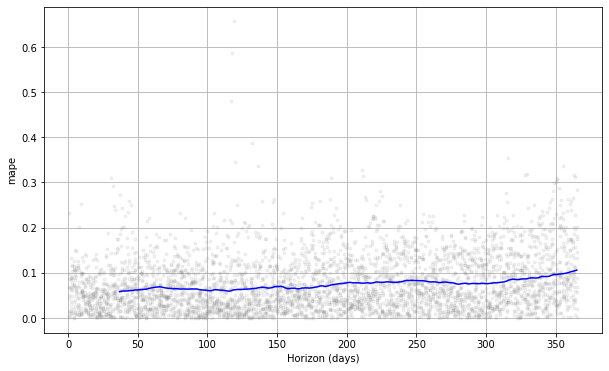

In [128]:
# MAPE plot
# Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. 
# We see for this forecast that errors around 5% are typical for predictions one month into the future, and that errors increase up to around 11% for predictions that are a year out.
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

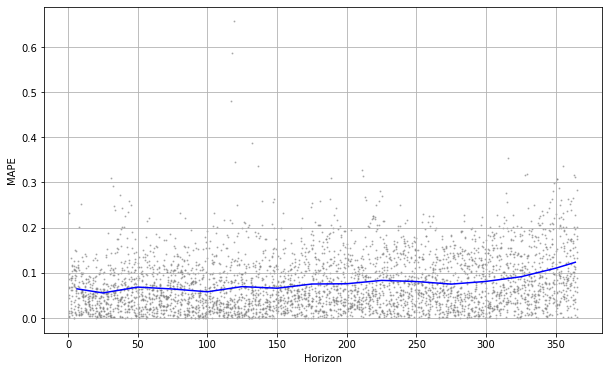

In [129]:
# Reproduce the Plot (roughly)
import matplotlib.pyplot as plt

plot_df = pd.DataFrame({ 
  'x': ( df_cv['ds'] - df_cv['cutoff'] ) / np.timedelta64(1, 'D'), 
  'y': np.abs(( df_cv['y'] - df_cv['yhat'] ) / df_cv['y'])  })

plot_df['x2'] = round( plot_df['x'] / 25 )

line_df = pd.DataFrame({ 
  'x': plot_df.groupby('x2')['x'].mean(),
  'y': plot_df.groupby('x2')['y'].mean() })

ax = plt.axes()
ax.scatter(plot_df['x'], plot_df['y'], s=1, c='gray', alpha=0.5)
ax.plot(line_df['x'], line_df['y'], c='blue')
ax.set_xlabel('Horizon')
ax.set_ylabel('MAPE')
ax.grid('on', which='major', axis='x' )
ax.grid('on', which='major', axis='y' )
plt.gcf().set_size_inches((10, 6))    
plt.show()


In [130]:
# Check MAPE by forecast (for each cutoff)
def mape(dfx):
    return round(np.mean( np.abs(( dfx['y'] - dfx['yhat'] ) / dfx['y']) ) * 100, 2)

df_cv.groupby(['cutoff']).apply(mape)

cutoff
2010-02-15    13.73
2010-08-14    12.12
2011-02-10     4.45
2011-08-09     5.33
2012-02-05     6.26
2012-08-03    11.86
2013-01-30     4.81
2013-07-29     7.47
2014-01-25     5.46
2014-07-24     6.06
2015-01-20     5.35
dtype: float64

In [131]:
# Parallelizing cross validation
# - Modes:
#      parallel=None (Default, no parallelization)
#      parallel="processes"  (highest performance on  single machine, recommended for problems that are not too big)
#      parallel="threads"
#      parallel="dask"  (uses Dask cluster to cross validate on many machines, separate install required, recommended for large problems.)


#from dask.distributed import Client
#client = Client()  # connect to the cluster
#df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel="dask")

In [132]:
# Hyperparameter tuning
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t3n_d8m/vw5b0bq5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t3n_d8m/hs7cvuo7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98086', 'data', 'file=/tmp/tmp4t3n_d8m/vw5b0bq5.json', 'init=/tmp/tmp4t3n_d8m/hs7cvuo7.json', 'output', 'file=/tmp/tmp4t3n_d8m/prophet_model55w22_td/prophet_model-20221218002959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:29:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:29:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f2436fde6a0>
DEBUG:cmdstanpy:input tempfile

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.757572
1                     0.001                     0.10  0.755242
2                     0.001                     1.00  0.753498
3                     0.001                    10.00  0.759586
4                     0.010                     0.01  0.544645
5                     0.010                     0.10  0.541304
6                     0.010                     1.00  0.528225
7                     0.010                    10.00  0.520748
8                     0.100                     0.01  0.522026
9                     0.100                     0.10  0.519338
10                    0.100                     1.00  0.520654
11                    0.100                    10.00  0.516703
12                    0.500                     0.01  0.534293
13                    0.500                     0.10  0.525506
14                    0.500                     1.00  0

In [133]:
# Find optimal
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


Reminder: Typical parameters that can be optimized:

*  **changepoint_prior_scale**: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.

*  **seasonality_prior_scale**: This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

* **holidays_prior_scale**: This controls flexibility to fit holiday effects. Similar to seasonality_prior_scale, it defaults to 10.0 which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of [0.01, 10] as with seasonality_prior_scale.

*  **seasonality_mode**: Options are ['additive', 'multiplicative']. Default is 'additive', but many business time series will have multiplicative seasonality. This is best identified just from looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series (see the documentation here on multiplicative seasonality), but when that isn’t possible, it could be tuned.

In [134]:
# Full Cleanup
d = dir()
for obj in d:
    if not obj.startswith('_'):
        del globals()[obj]
del obj

## **End**